# **Performance Evaluation Agent**

To evaluate the performance of our recommender system, we will analyze the system regarding the individual agents’ performance, the cold start problem, the sensitivity to changes in the recommendation hyperparameter and potential energy cost savings. We will introduce a further agent called Evaluation Agent which will perform all evaluation actions.

We will perform our evaluation analysis for households 1 to 10 in the REFIT: Electrical Load Measurements data (Murray et at., 2019), to validate our evaluation results.


## **1. Preparing the Environment**

In [1]:
import yaml
from agents import Performance_Evaluation_Agent
from helper_functions import Helper

helper = Helper()

import pandas as pd
import numpy as np
import json
import pickle
from copy import deepcopy
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


import scipy.spatial

In [2]:
DATA_PATH = '../data/'
EXPORT_PATH = '../export/'

<br>

## **2. Preparations for Evaluating the Performance of our Recommender System**
### **2.1 Determining User Input**

Before we are able to use our recommender system and evaluate its performance, we need to specify the required user inputs (i.e. active appliances, shiftable devices and the consumption threshold). For specifying which of the devices in the respective household will be determined as active appliances and shiftable devices, we look at the description of the devices provided in the readme file and categorize the devices according to our definitions of the categories. Furthermore, we validate that the used devices do not contain any noise in their consumption data and remove devices which contain noise, i.e. consume energy constantly over time. 

In [3]:
readme = DATA_PATH+'REFIT_Readme.txt'
readme = helper.load_txt(readme)
start = readme.rfind('House 1\n')
end = readme.find('House 11\n')
print(readme[start:end])

House 1
0.Aggregate, 1.Fridge, 2.Chest Freezer, 3.Upright Freezer, 4.Tumble Dryer,
5.Washing Machine, 6.Dishwasher, 7.Computer Site, 8.Television Site, 9.Electric Heater
	!NOTES
		0. October 2014, numerous light bulbs changed to LEDs.
		7.a Desktop Computer
		7.b Computer Monitor

House 2
0.Aggregate, 1.Fridge-Freezer, 2.Washing Machine, 3.Dishwasher, 4.Television,
5.Microwave, 6.Toaster, 7.Hi-Fi, 8.Kettle, 9.Oven Extractor Fan
	!NOTES

House 3
0.Aggregate, 1.Toaster, 2.Fridge-Freezer, 3.Freezer, 4.Tumble Dryer,
5.Dishwasher, 6.Washing Machine, 7.Television, 8.Microwave, 9.Kettle
	!NOTES

House 4
0.Aggregate, 1.Fridge, 2.Freezer, 3.Fridge-Freezer, 4.Washing Machine (1),
5.Washing Machine (2), 6.Computer Site, 7.Television Site, 8.Microwave, 9.Kettle
	!NOTES
		6.a Desktop Computer
		6.b Computer Monitor
		6.c Scanner
		6.d Printer
		6.e Router
		6. Change in signature 01/02/2015
		7.a Television
		7.b DVD Player
		7.c VHS Player
		7. Change in signature 19/12/2014

House 5
0.Aggregate, 

<br>

**Shiftable Devices**

In [4]:
# manual input, determined using information provided in the readme
# validated in the next step using the validate thresholds functionality
shiftable_devices = {
    1: ['Tumble Dryer', 'Washing Machine', 'Dishwasher'],
    2: ['Washing Machine', 'Dishwasher'],
    3: ['Tumble Dryer', 'Washing Machine', 'Dishwasher'],
    4: ['Washing Machine (1)', 'Washing Machine (2)'],
    5: ['Tumble Dryer'], # , 'Washing Machine' --> consumes energy constantly; , 'Dishwasher' --> noise at 3am
    6: ['Washing Machine', 'Dishwasher'],
    7: ['Tumble Dryer', 'Washing Machine', 'Dishwasher'],
    8: ['Washing Machine'], # 'Dryer' --> consumes constantly
    9: ['Washer Dryer', 'Washing Machine', 'Dishwasher'], 
    10: ['Washing Machine'] #'Dishwasher'
}

<br>

**Active Appliances**

In [5]:
# manual input, determined using information provided in the readme
# validated in the next step using the validate thresholds functionality
active_appliances = {
    1: deepcopy(shiftable_devices[1]) + ['Television Site', 'Computer Site'],
    2: deepcopy(shiftable_devices[2]) + ['Television', 'Microwave', 'Toaster', 'Hi-Fi', 'Kettle'],
    3: deepcopy(shiftable_devices[3]) + ['Toaster', 'Television', 'Microwave', 'Kettle'],
    4: deepcopy(shiftable_devices[4]) + ['Television Site', 'Kettle'], #'Microwave', 'Computer Site' --> consume energy constantly 
    5: deepcopy(shiftable_devices[5]) + ['Television Site', 'Combination Microwave', 'Kettle', 'Toaster'], # 'Computer Site', --> consumes energy constantly
    6: deepcopy(shiftable_devices[6]) + ['MJY Computer', 'Kettle', 'Toaster'], #, 'PGM Computer', 'Television Site' 'Microwave' --> consume energy constantly 
    7: deepcopy(shiftable_devices[7]) + ['Television Site', 'Toaster', 'Kettle'],
    8: deepcopy(shiftable_devices[8]) + ['Toaster', 'Kettle'], # 'Television Site', 'Computer' --> consume energy constantly
    9: deepcopy(shiftable_devices[9]) + ['Microwave', 'Kettle'], #'Television Site', 'Hi-Fi' --> consume energy constantly
    10: deepcopy(shiftable_devices[10]) + ['Magimix (Blender)', 'Microwave'] # 'Television Site' --> consume energy constantly
}

<br>

**Energy Consumption Threshold**

Our Preparation Agent will require the energy consumption threshold, which will determine if a device was used in a given period. This threshold will allow to reduce the impact of noise in the data. We will determine the optimal thresholds for the households using the Preparation Agent’s validate thresholds method. To demonstrate how noise in the consumption data occurs, we call the validate thresholds method for household 1. The consumption data regarding the Television Site in household 1 seems to contain daily noise around 3 am. We will choose the optimal threshold, such that the noise is removed from the data.

Furthermore, we will create our initial evaluation configuration file for each household which will contain the specified user input.

In [6]:
# validating the thresholds for household 1 to show noise in the data
household_id = 1

In [7]:
# creating the config including the user input
config =  {'data': {'household': deepcopy(household_id)}}
config['user_input'] = {
    'shiftable_devices': deepcopy(shiftable_devices[config['data']['household']]),
    'active_appliances': deepcopy(active_appliances[config['data']['household']])
}
# ada acts weird, logit is alright, random forest is alright, knn is okay, xgboost ok
# initializing the evaluation agent
evaluation = Performance_Evaluation_Agent(DATA_PATH, 'xgboost', config, load_data=True, weather_sel=True)

100%|██████████| 6/6 [00:02<00:00,  2.54it/s]




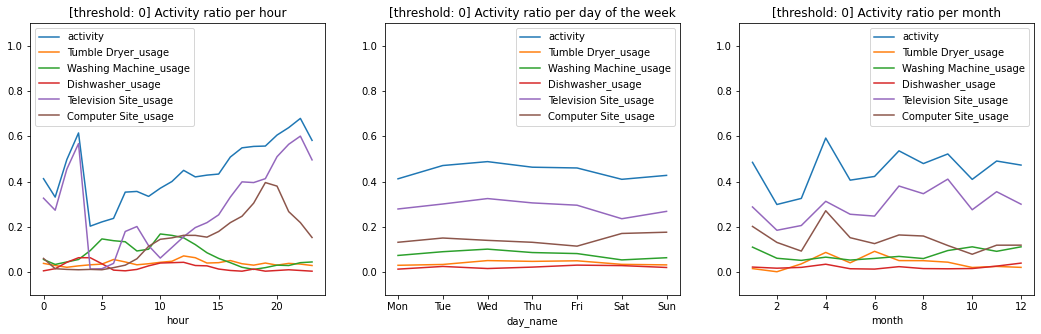

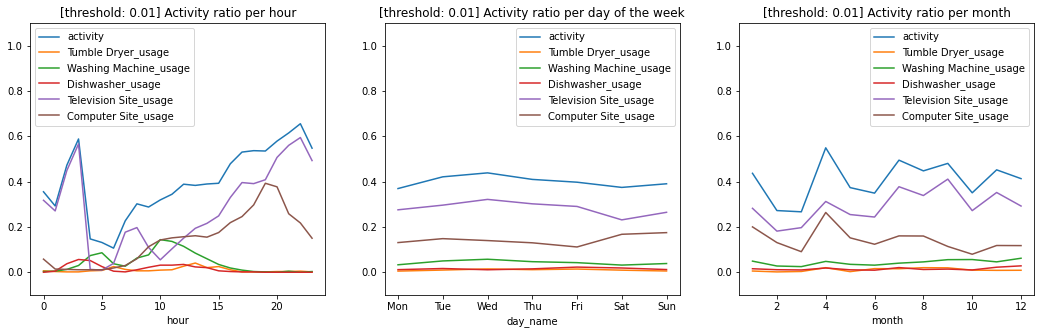

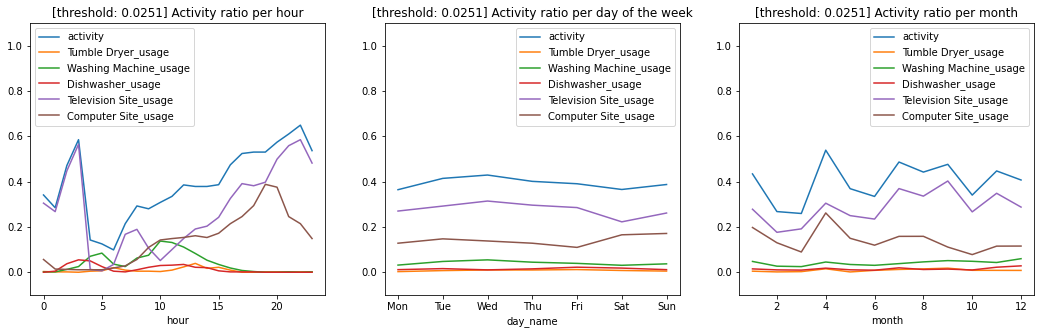

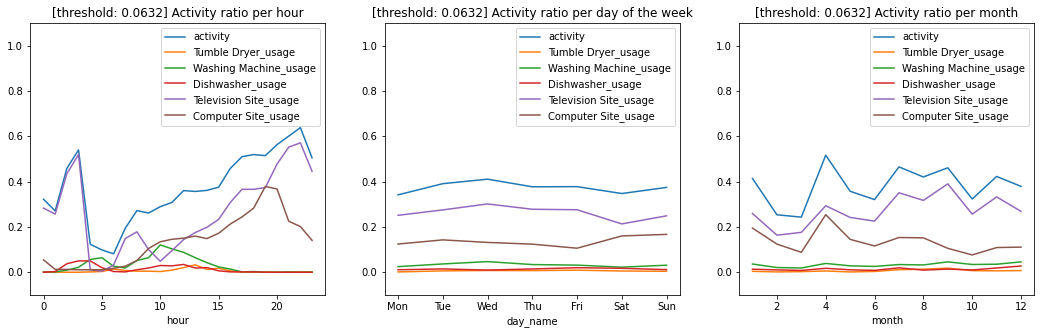

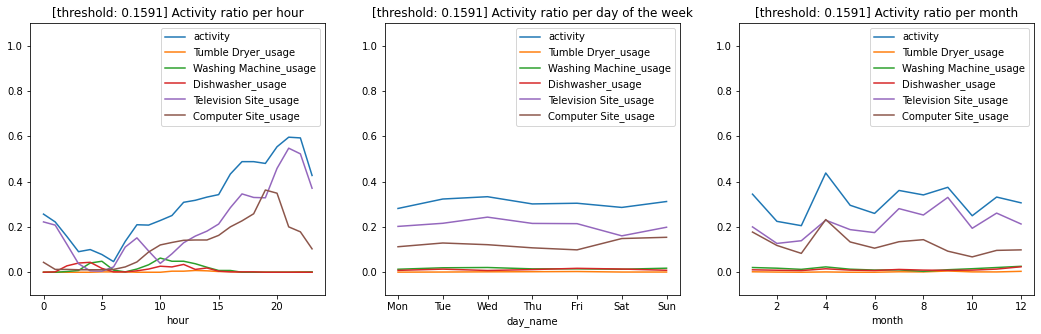

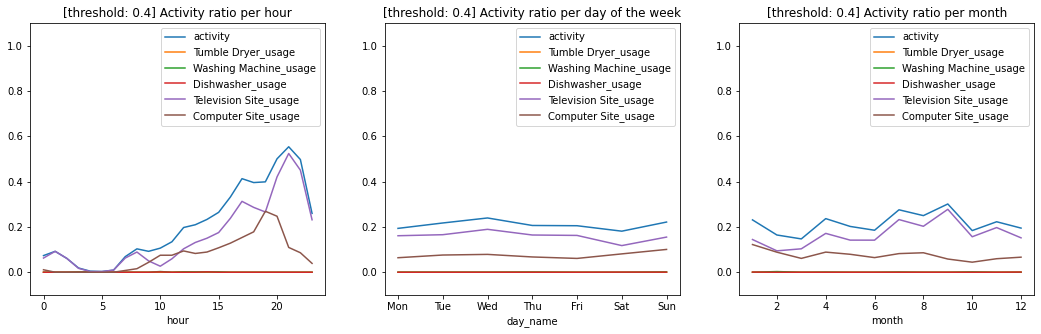

In [10]:
preparation = evaluation.preparation

# Data-Preparation
df_th = preparation.truncate(preparation.input)
df_th = preparation.scale(df_th)
df_th = helper.aggregate(df_th, '60T')

# Graphical analysis of candidate thresholds
thresholds = [0] + list(np.geomspace(.01, .4, 5))
preparation.validate_thresholds(df_th, thresholds, config['user_input']['active_appliances'])

In [8]:
thresholds = {
    1: 0.15,
    2: 0.01,
    3: 0.01, 
    4: 0.01, 
    5: 0.025,
    6: 0.065, 
    7: 0.01, 
    8: 0.01, # washing machine over night
    9: 0.01, 
    10: 0.01
}

<br>

### **2.2 Running our Pipeline**

Before we are able to analyze the performance of our recommender system, we need to calculate all outputs of all our agents and all recommendations possible based on the available data. To conveniently compute these outputs and recommendations for the households, we added a pipeline method to the Evaluation Agent which allows to run every agent of our recommender system for every available date iteratively. We will demonstrate its functionality by creating the recommendations for household 3. 

Additionally, we will use a further method of the Evaluation Agent to receive the default configuration for evaluating our recommender system.

In [9]:
household_id = 3

In [10]:
# creating the config including the user input
config =  {'data': {'household': deepcopy(household_id)}}
config['user_input'] = {
    'shiftable_devices': deepcopy(shiftable_devices[config['data']['household']]),
    'active_appliances': deepcopy(active_appliances[config['data']['household']]),
    'threshold': deepcopy(thresholds[config['data']['household']])
}

<br>

**Preparing the data**

In [21]:
# calling the evaluation agent
evaluation = Performance_Evaluation_Agent(DATA_PATH, 'xgboost',config)
evaluation.get_default_config('preparation')
evaluation.config

{'data': {'household': 3,
  'first_date': '2013-09-26',
  'last_date': '2015-06-01',
  'start_dates': {'activity': '2013-09-29',
   'usage': '2013-10-05',
   'load': '2013-09-26',
   'usage_tumble_dryer': '2013-10-05',
   'usage_washing_machine': '2013-10-05',
   'usage_dishwasher': '2013-10-05',
   'combined': '2013-10-05'}},
 'user_input': {'shiftable_devices': ['Tumble Dryer',
   'Washing Machine',
   'Dishwasher'],
  'active_appliances': ['Tumble Dryer',
   'Washing Machine',
   'Dishwasher',
   'Toaster',
   'Television',
   'Microwave',
   'Kettle'],
  'threshold': 0.01},
 'preparation': {'activity': {'truncate': {'features': 'all',
    'factor': 1.5,
    'verbose': 0},
   'scale': {'features': 'all', 'kind': 'MinMax', 'verbose': 0},
   'aggregate': {'resample_param': '60T'},
   'activity': {'active_appliances': ['Tumble Dryer',
     'Washing Machine',
     'Dishwasher',
     'Toaster',
     'Television',
     'Microwave',
     'Kettle'],
    'threshold': 0.01},
   'time': {'feat

In [22]:
evaluation.pipeline('preparation')

[evaluation agent] Finished preparing the data for the activity agent.
[evaluation agent] Finished preparing the data for the usage agent.
[evaluation agent] Finished preparing the data for the load agent.


In [23]:
evaluation.df['activity'][100:105]

,activity,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,,
2013-09-29 23:00:00,0,23,0.0,0.0,0.0,0,0,1,0,0,0
2013-09-30 00:00:00,0,0,0.0,0.0,0.0,1,0,0,0,0,0
2013-09-30 01:00:00,0,1,0.0,1.0,0.0,1,0,0,0,0,0
2013-09-30 02:00:00,0,2,0.0,1.0,0.0,1,0,0,0,0,0
2013-09-30 03:00:00,0,3,0.0,0.0,0.0,1,0,0,0,0,0


In [24]:
evaluation.df['activity'].columns

Index(['activity', 'hour', 'activity_lag_24', 'activity_lag_48',
       'activity_lag_72', 'day_name_Monday', 'day_name_Saturday',
       'day_name_Sunday', 'day_name_Thursday', 'day_name_Tuesday',
       'day_name_Wednesday'],
      dtype='object')

In [25]:
evaluation.df['usage'][100:105]

,activity,Tumble Dryer_usage,Washing Machine_usage,Dishwasher_usage,periods_since_last_activity,periods_since_last_Tumble Dryer_usage,periods_since_last_Washing Machine_usage,periods_since_last_Dishwasher_usage,hour,activity_lag_1,...,Dishwasher_usage_lag_1,Dishwasher_usage_lag_2,Dishwasher_usage_lag_3,active_last_2_days,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,,,,,,,,,,,,
2014-01-03,1,1,1,1,1.0,1.0,1.0,2.0,0,1.0,...,0.0,1.0,0.0,1,0,0,0,0,0,0
2014-01-04,1,1,0,1,1.0,1.0,1.0,1.0,0,1.0,...,1.0,0.0,1.0,1,0,1,0,0,0,0
2014-01-05,1,1,1,1,1.0,1.0,2.0,1.0,0,1.0,...,1.0,1.0,0.0,1,0,0,1,0,0,0
2014-01-06,1,0,0,0,1.0,1.0,1.0,1.0,0,1.0,...,1.0,1.0,1.0,1,1,0,0,0,0,0
2014-01-07,1,0,0,1,1.0,2.0,2.0,2.0,0,1.0,...,0.0,1.0,1.0,1,0,0,0,0,1,0


In [26]:
evaluation.df['load'][335:340]

,Tumble Dryer,Washing Machine,Dishwasher
Time,,,
2013-10-09 18:00:00,0.0,0.0,0.0
2013-10-09 19:00:00,0.0,0.0,0.0
2013-10-09 20:00:00,0.0,0.0,0.0
2013-10-09 21:00:00,0.0,0.0,0.0
2013-10-09 22:00:00,0.0,0.0,0.0


<br>

**Creating all recommendations**


In [18]:
evaluation.get_default_config(['activity', 'usage', 'load'])
evaluation.config

{'data': {'household': 3,
  'first_date': '2013-09-26',
  'last_date': '2015-06-01',
  'start_dates': {'activity': '2013-09-29',
   'usage': '2013-10-05',
   'load': '2013-09-26',
   'usage_tumble_dryer': '2013-10-05',
   'usage_washing_machine': '2013-10-05',
   'usage_dishwasher': '2013-10-05',
   'combined': '2013-10-05'}},
 'user_input': {'shiftable_devices': ['Tumble Dryer',
   'Washing Machine',
   'Dishwasher'],
  'active_appliances': ['Tumble Dryer',
   'Washing Machine',
   'Dishwasher',
   'Toaster',
   'Television',
   'Microwave',
   'Kettle'],
  'threshold': 0.01},
 'preparation': {'activity': {'truncate': {'features': 'all',
    'factor': 1.5,
    'verbose': 0},
   'scale': {'features': 'all', 'kind': 'MinMax', 'verbose': 0},
   'aggregate': {'resample_param': '60T'},
   'activity': {'active_appliances': ['Tumble Dryer',
     'Washing Machine',
     'Dishwasher',
     'Toaster',
     'Television',
     'Microwave',
     'Kettle'],
    'threshold': 0.01},
   'time': {'feat

In [27]:
evaluation.pipeline(['activity','usage','load']) 
#evaluation.pipeline('recommendation', activity_threshold=0.625, usage_threshold=0.125)

agent:		load
progress: 	614/614
time:		[19:05<00:00]

                         h1          h2          h3         h4         h5  \
Tumble Dryer     712.256488  341.869906  116.022231  59.712949  33.156928   
Washing Machine  146.987549   86.275832   35.139014  17.643711   9.037951   
Dishwasher       117.363011  160.292822    9.845558   2.183648   0.497150   

                        h6        h7        h8       h9       h10  ...  h15  \
Tumble Dryer     11.954180  5.738580  1.444243  0.00000  0.000000  ...  0.0   
Washing Machine   3.771159  1.192733  1.450442  0.46657  0.487798  ...  0.0   
Dishwasher        0.403743  0.000000  0.000000  0.00000  0.000000  ...  0.0   

                 h16  h17  h18  h19  h20  h21  h22  h23  h24  
Tumble Dryer     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
Washing Machine  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
Dishwasher       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 24 columns]


In [28]:
evaluation.pipeline('recommendation', activity_threshold=0.625, usage_threshold=0.125)

In [29]:
evaluation.output['recommendation']

,device,best_launch_hour,no_recommend_flag_activity,no_recommend_flag_usage,recommendation
recommendation_date,,,,,
2013-10-05,Tumble Dryer,4,0,0,4.0
2013-10-05,Washing Machine,4,0,0,4.0
2013-10-05,Dishwasher,4,0,0,4.0
2013-10-06,Tumble Dryer,4,0,0,4.0
2013-10-06,Washing Machine,4,0,0,4.0
...,...,...,...,...,...
2015-05-31,Washing Machine,7,0,0,7.0
2015-05-31,Dishwasher,7,0,0,7.0
2015-06-01,Tumble Dryer,21,0,0,21.0


In [ ]:
evaluation.dump(EXPORT_PATH)

<br>
<br>
<br>

## **3. Evaluating the Performance of our Recommender System**

Our goals for evaluating our recommender systems performance are to measure the performance of the individual agents (i.e. Activity Agent, Usage Agent, Load Agent), to quantify the cold start problem of our recommender system, to analyze the sensitivity of our system to changes in the recommendation hyperparameter (i.e. activity threshold and usage threshold) as well as to calculate the potential energy cost savings for the user.

### **3.1. Evaluating the Performance of the Individual Agents** 

To measure the performance the Activity Agent, the Usage Agent and the Load Agent, we will use the agents’ own evaluation methods. Hence, evaluation method of the Activity Agent and the Usage Agent will calculate the Area under the ROC curve (i.e. AUC score). It will use all daily predictions received from running the pipeline from above, combine the predictions to one dataset and use this dataset to calculate the AUC scores. For the Load Agent, its evaluation method will extract all load profiles for the actual devices runs in the data and compare them to the respective typical load profile which is available at the date of the actual run. To summarize the performance the evaluation method will calculate the mean squared error for all device runs and will aggregate the scores to a single score by averaging over all device runs (i.e. MSE score). After finishing the evaluation of the individual agents’ performance, we will receive one AUC score for the Activity Agent per household as well as one usage AUC score and one load MSE score per shiftable device of the respective household.

All necessary steps to calculate the performance of the individual agents can be called using a single method of the Evaluation Agent.


In [ ]:
household_id = 3

config = json.load(open(EXPORT_PATH + str(household_id) + '_config.json', 'r'))
files = ['df.pkl', 'output.pkl']
files = [f"{EXPORT_PATH}{household_id}_{file}" for file in files]

# initializing the agent
evaluation = Evaluation_Agent(DATA_PATH, config, load_data=True, load_files=files)
evaluation.init_agents()

In [ ]:
evaluation.get_agent_scores()

<br>

**Converting agent scores to tabular structure for comparison with further households**

As each household has different shiftable devices, we will assign each shiftable device in each household with an integer index. Using these indices, we are able to create an overview on the individual agent scores over different households. To connect the indices with the actual device name we will create a legend for the shiftable devices using our helper functions.

In [ ]:
helper.shiftable_device_legend(EXPORT_PATH).fillna('-')

In [ ]:
agent_scores = {}
agent_scores[household_id] = evaluation.agent_scores_to_summary()
helper.concat_household_scores(agent_scores).round(2)

## 3.3 Evaluating the Sensitivity of our Recommender System to Changes in the Recommendation Hyperparameter

The ultimate goal of evaluating our framework is to analyze the potential energy cost savings for our user. To evaluate the cost savings for each recommendation, we will start by determining whether a recommendation provided by framework would be acceptable for the user. A recommendation is considered acceptable, if both the activity target and the device usage target are positive for the recommended starting hour and device. Furthermore, we will calculate the cost savings for the acceptable recommendations. These cost savings are determined by the cost for running the device according to our recommendation and the cost for the relevant run which the user performed without receiving our recommendation. If the user ran the device multiple times on the day for which a recommendation was provided, the relevant run was defined as the run for which the starting time is closest to the recommended starting hour. As we use industry day-ahead energy prices in our recommender system, the absolute savings do not represent a realistic prediction of cost savings on the household level. However, the relative saving which compares the energy costs while accepting the recommendation to the energy costs without the recommendation is a more appropriate to measure our recommender system’s performance.

Since we calculate the cost savings for each recommendation, we will aggregate our evaluation results to summarize the performance of our recommender system to a few metrics. The performance will be determined by the number of recommendations provided, the acceptance rate of the provided recommendations, the total savings and the relative savings.

For creating our recommendations, we need to specify the two hyperparameter, i.e. activity threshold and usage threshold. We tune the parameters using a grid search over candidate thresholds. We will use the results from the grid search to analyze the sensitivity of the recommendation timing and the performance metrics to changes in the hyperparameter as well as determining optimal values for these parameters. We defined the optimal hyperparameter as the parameter combination which will lead to the highest total savings.



## Calculating Savings for Given Hyperparameter

In [ ]:
evaluation.evaluate(0.625, 0.125)
list(evaluation.results.values())[0]

In [ ]:
evaluation.results_to_summary().round(2)

## Grid Search over Candidate Hyperparameter Values

In [ ]:
steps = 8
activity_thresholds = np.linspace(1/(steps), 1, steps)[:-1]
usage_thresholds = np.linspace(1/steps, 1, steps)[:-1]
print(f"[grid search] candidate thresholds {activity_thresholds}\n")
time.sleep(0.3)
evaluation.grid_search(activity_thresholds, usage_thresholds)

In [ ]:
evaluation.results_to_summary().round(2)

<br>

**Sensitivity of the Timing of Recommendations**

We will use the results from the grid search to analyze the changes in recommendation timing for different hyperparameter. As the device usage is predicted on a daily level, changes in the usage threshold will not lead to changes in the hours in which the recommendation will be made. Therefore, we will analyze the changes in recommendation timings for a constant usage threshold and a changing activity threshold. 

Additionally, we will compare the timing of the recommendations to the average energy price per hour and the average activity of the user per hour to identify potential patterns.

In [ ]:
# comparing the recommendation timings to average activity per hour and average price per hour
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

prices = pd.DataFrame(evaluation.price.input)
prices['hour'] = list(prices.index.map(lambda x: x.hour))
prices.groupby(by='hour').mean().plot(ax=axes[0])
axes[0].set(title='average price per hour', ylabel='average price');

activity = evaluation.activity.input[['hour', 'activity']]
activity.groupby(by='hour').mean().plot(ax=axes[1])
axes[1].set(title='average activity per hour', ylabel='average avtivity');

<br>

**Sensitivity of our Performance Measures**

In [ ]:
n_cols = int(np.ceil(np.sqrt(evaluation.results_to_summary().shape[1])))
n_rows = int(np.ceil(evaluation.results_to_summary().shape[1] / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18,10))
axes = axes.reshape(-1,)

columns = list(evaluation.results_to_summary().columns)
for i in range(axes.shape[0]):
    try:
        col = columns[i]
        sensitivity = evaluation.get_sensitivity(col)
        sns.heatmap(sensitivity, ax=axes[i])
        axes[i].set(title=f"heatmap: {col}")
    except IndexError:
        axes[i].remove()

<br>

**Determining the Optimal Recommendation Hyperparameter**

In [ ]:
optimal_thresholds = evaluation.get_optimal_thresholds()
optimal_thresholds_index = evaluation.thresholds_to_index()
optimal_thresholds

In [ ]:
results = pd.DataFrame()
results = results.append(evaluation.optimal_result_to_summary())
results = results[['activity_threshold', 'usage_threshold', 'acceptable', 'n_recommendations', 'relative_savings_mean', 'total_savings']]
results

In [ ]:
# timing of optimal recommendations
evaluation.results[optimal_thresholds_index]['recommendation'].hist();
plt.ylabel('recommendation count')
plt.xlabel('hour of the day')
plt.title('Timing of optimal recommendations');

In [ ]:
evaluation.dump(EXPORT_PATH)

<br>
<br>
<br>

## **4. Performing the Evaluation on Multiple Households**

To validate our findings, we will perform the evaluation steps presented above on households 1 to 10.

In [ ]:
# cold start: metrics
euclidean = scipy.spatial.distance.euclidean
magnitude = lambda v: np.sqrt(np.dot(v.values.reshape(-1), v.values.reshape(-1)))
norm_euclidean = lambda y_true, y_hat: euclidean(y_true, y_hat) / magnitude(y_true)

metrics =     {
    'activity': 'auc',
    'usage': 'auc',
    'load': 'norm_euclidean'
}

# cold start: tolerance values
tolerance = [0.05, 0.1, 0.15, 0.2, 0.25]

In [ ]:
steps = 8
activity_thresholds = np.linspace(1/(steps), 1, steps)[:-1]
usage_thresholds = np.linspace(1/steps, 1, steps)[:-1]
print(f"[grid search] candidate thresholds {list(activity_thresholds)}\n")

In [ ]:
households = shiftable_devices.keys()

agent_scores = {}
cold_start_days = {}
results = pd.DataFrame()

for household_id in households:
    
    # creating the configuration file
    config =  {'data': {'household': deepcopy(household_id)}}
    config['user_input'] = {
        'shiftable_devices': deepcopy(shiftable_devices[config['data']['household']]),
        'active_appliances': deepcopy(active_appliances[config['data']['household']]),
        'threshold': deepcopy(thresholds[config['data']['household']])
    }

    # initializing the evaluation agent
    evaluation = Evaluation_Agent(DATA_PATH, config)

    # running the pipeline
    # ---------------------------------------------------------------------------------
    # preparing the input data
    evaluation.get_default_config('preparation')
    evaluation.pipeline('preparation')
    
    # creating all recommendations
    evaluation.get_default_config(['activity', 'usage', 'load'])
    evaluation.pipeline(['activity', 'usage', 'load'])

    # storing intermediary results
    evaluation.dump(EXPORT_PATH)
    
    # evaluating the performance of the induvidual agents
    # ---------------------------------------------------------------------------------
    evaluation.get_agent_scores()
    agent_scores[household_id] = evaluation.agent_scores_to_summary()
    
    # evaluating the performance of the induvidual agents
    # ---------------------------------------------------------------------------------
    evaluation.get_cold_start_scores(fn={'load': norm_euclidean})
    evaluation.get_cold_start_days(tolerance_values=tolerance)
    cold_start_days[household_id] = evaluation.cold_start_to_summary(tolerance)
    
    # evaluating the performance of the framework + parameter tuning
    # ---------------------------------------------------------------------------------
    evaluation.grid_search(activity_thresholds, usage_thresholds)
    results = results.append(evaluation.optimal_result_to_summary())
    
    # storing the results
    evaluation.dump(EXPORT_PATH)

In [ ]:
legend = helper.shiftable_device_legend(EXPORT_PATH)
legend.fillna('-')

<br>

**Performance of the Individual Agents**

In [ ]:
with open(EXPORT_PATH+'agent-scores.pkl', 'wb') as file:
    pickle.dump(agent_scores, file)

In [ ]:
agent_scores_summary = helper.concat_household_scores(agent_scores).round(2).fillna('-')
agent_scores_summary

<br>

**Cold Start Analysis**

In [ ]:
cold_start_days_df = helper.concat_household_scores(cold_start_days)

tolerance_index = 2
print(f"[cold start] tolerance value: {tolerance[tolerance_index]}")

for i in range(cold_start_days_df.shape[0]):
    for j in range(cold_start_days_df.shape[1]):
        try:
            cold_start_days_df.iloc[i,j] = cold_start_days_df.iloc[i,j][tolerance_index]
        except TypeError:
            pass
cold_start_days_df.fillna('-')

In [ ]:
with open(EXPORT_PATH+'cold-start-days.pkl', 'wb') as file:
    pickle.dump(cold_start_days, file)

<br>

**Perfomance of our Recommender System**

In [ ]:
results = results[['activity_threshold', 'usage_threshold', 'acceptable', 'n_recommendations', 'relative_savings_mean', 'total_savings']]
results.round(2)

In [ ]:
with open(EXPORT_PATH+'results.pkl', 'wb') as file:
    pickle.dump(results, file)

<br>
<br>
<br>

## **Reference List**

Murray, D., Stankovic, L., & Stankovic, V. (2017). An electrical load measurements datasetof united kingdom households from a two-year longitudinal study [data set]. *Scientific Data*.

<br>
<br>
<br>

## **Appendix A1: Complete Evaluation Agent Class**

In [ ]:
class Evaluation_Agent:
    def __init__(self, DATA_PATH, config, load_data=True, load_files=None):
        import agents
        from helper_functions import Helper
        import pandas as pd

        helper = Helper()

        self.config = config
        self.preparation = (agents.Preparation_Agent(helper.load_household(DATA_PATH, config["data"]["household"]))
            if load_data
            else None
        )
        self.price = (
            agents.Price_Agent(helper.create_day_ahead_prices_df(DATA_PATH, "Day-ahead Prices_201501010000-201601010000.csv"))
            if load_data
            else None
        )
        self.activity = None
        self.load = None
        for device in self.config["user_input"]["shiftable_devices"]:
            name = ("usage_"+ device.replace(" ", "_").replace("(", "").replace(")", "").lower())
            exec(f"self.{name} = None")
        self.recommendation = None
        self.df = {}
        self.output = {}
        self.errors = {}
        self.agent_scores = {} 
        self.cold_start_scores = {}
        #self.true_loads = None
        self.results = {}
        self.cold_start_days = pd.DataFrame()
        if load_files != None:
            self.load_from_drive(load_files)

    # helper: loading and storing intermediary results and further helper
    # -------------------------------------------------------------------------------------------
    def _load_object(self, filename):
        import pickle
        import json
        import yaml

        # using a command dict as a if-list
        commands = {
            "pkl": f"pickle.load(open('{filename}', 'rb'))",
            "json": f"json.load(open('{filename}', 'r'))",
            "yaml": f"yaml.load(open('{filename}', 'r'), Loader = yaml.Loader)",
        }

        *_, name, ftype = filename.split(".")
        name = name[name.rfind("_") + 1 :]
        obj = eval(commands[ftype])
        self[name] = obj

    def load_from_drive(self, files):
        files = [files] if type(files) != list else files
        for filename in files:
            self._load_object(filename)

    def dump(self, EXPORT_PATH):
        import json
        import yaml
        import pickle

        # storing the current configuration
        json.dump(self.config, open(EXPORT_PATH + str(self.config["data"]["household"]) + "_config.json","w"), indent=4)

        # storing the prepared data
        if self.df != {}:
            pickle.dump(self.df, open(EXPORT_PATH + str(self.config["data"]["household"]) + "_df.pkl", "wb"))

        # storing the agents' output
        if self.output != {}:
            pickle.dump(self.output, open(EXPORT_PATH + str(self.config["data"]["household"]) + "_output.pkl", "wb"))
            
        # storing the results
        if self.results != {}:
            pickle.dump(self.results, open(EXPORT_PATH + str(self.config["data"]["household"]) + "_results.pkl", "wb"))
            
    def __getitem__(self, item):
        return eval(f"self.{item}")

    def __setitem__(self, key, value):
        exec(f"self.{key} = value")

    def _format_time(self, seconds):
        return "{:02.0f}".format(seconds // 60) + ":" + "{:02.0f}".format(seconds % 60)
    
    def _get_agent_names(self):
        devices = self.config["user_input"]["shiftable_devices"]
        names = ["activity", "load"] + ["usage_"+ str(device).replace(" ", "_").replace("(", "").replace(")", "").lower() for device in devices]
        return names

    
    # creating the default configuration
    # -------------------------------------------------------------------------------------------
    def get_default_config(self, agents):
        if type(agents) != list:
            agents = [agents]
        
        agents = [agent.lower() for agent in agents]
        for agent in agents:
            exec(f"self._get_default_{agent}_config()")     
            
    def _get_default_preparation_config(self):
        from copy import deepcopy

        # preparation
        self.config["preparation"] = {}
        ## preparation: activity agent
        self.config["preparation"]["activity"] = {
            "truncate": {"features": "all", "factor": 1.5, "verbose": 0},
            "scale": {"features": "all", "kind": "MinMax", "verbose": 0},
            "aggregate": {"resample_param": "60T"},
            "activity": {
                "active_appliances": deepcopy(self.config["user_input"]["active_appliances"]),
                "threshold": deepcopy(self.config["user_input"]["threshold"]),
            },
            "time": {"features": ["hour", "day_name"]},
            "activity_lag": {"features": ["activity"], "lags": [24, 48, 72]},
        }
        ## preparation: usage agent
        self.config["preparation"]["usage"] = {
            "truncate": {"features": "all", "factor": 1.5, "verbose": 0},
            "scale": {"features": "all", "kind": "MinMax", "verbose": 0},
            "activity": {
                "active_appliances": deepcopy(self.config["user_input"]["active_appliances"]),
                "threshold": deepcopy(self.config["user_input"]["threshold"]),
            },
            "aggregate_hour": {"resample_param": "60T"},
            "aggregate_day": {"resample_param": "24H"},
            "time": {"features": ["hour", "day_name"]},
            "shiftable_devices": deepcopy(self.config["user_input"]["shiftable_devices"]),
            "device": {"threshold": deepcopy(self.config["user_input"]["threshold"])},
        }
        ## preparation: load agent
        self.config["preparation"]["load"] = {
            "truncate": {"features": "all", "factor": 1.5, "verbose": 0},
            "scale": {"features": "all", "kind": "MinMax", "verbose": 0},
            "aggregate": {"resample_param": "60T"},
            "shiftable_devices": deepcopy(self.config["user_input"]["shiftable_devices"]),
            "device": {"threshold": deepcopy(self.config["user_input"]["threshold"])},
        }

    def _get_default_activity_config(self):
        from copy import deepcopy
        
        if (self.activity == None):
            self.init_agents()
        self._get_dates()
        self.config["activity"] = {
            "model_type": "logit",
            "split_params": {
                "train_start": deepcopy(self.config["data"]["start_dates"]["activity"]),
                "test_delta": {"days": 1, "seconds": -1},
                "target": "activity",
            },
        }
        
    def _get_default_load_config(self):
        from copy import deepcopy
        
        if (self.load == None):
            self.init_agents()
        self._get_dates()
        self.config["load"] = {
            "shiftable_devices": deepcopy(self.config["user_input"]["shiftable_devices"])
        }
        
    def _get_default_usage_config(self):
        from copy import deepcopy
        
        if (self.activity == None) | (self.load == None):
            self.init_agents()
        self._get_dates()
        self.config["usage"] = {
            "model_type": "logit",
            "train_start": deepcopy(self.config["data"]["start_dates"]["usage"]),
        }
        for device in self.config["user_input"]["shiftable_devices"]:
            name = ("usage_"+ device.replace(" ", "_").replace("(", "").replace(")", "").lower())
            self.config[name] = self.config["usage"]
            self.config["data"]["start_dates"][name] = self.config["data"]["start_dates"]["usage"]
            
    # extracting the available dates in the data
    def get_first_date(self, df):
        import pandas as pd

        first_data = df.index.to_series()[0]
        return (first_data + pd.Timedelta("1D")).replace(hour=0, minute=0, second=0)

    def get_last_date(self, df):
        import pandas as pd

        last_data = df.index.to_series()[-1]
        return (last_data - pd.Timedelta("1D")).replace(hour=23, minute=59, second=59)

    def get_min_start_date(self, df):
        df = df.dropna()
        return df.loc[df.index.hour == 0, :].index[0]

    def _get_dates(self):
        import numpy as np

        # first and last date in the data
        self.config["data"]["first_date"] = str(self.get_first_date(self.preparation.input))[:10]
        self.config["data"]["last_date"] = str(self.get_last_date(self.preparation.input))[:10]
        # start dates
        start_dates = {}
        for agent, data in self.df.items():
            start_dates[agent] = self.get_min_start_date(data)
        start_dates["combined"] = np.max(list(start_dates.values()))
        self.config["data"]["start_dates"] = {
            key: str(value)[:10] for key, value in start_dates.items()
        }


    # running the pipeline
    # -------------------------------------------------------------------------------------------
    def pipeline(self, agents, **kwargs):
        # converting single agent to list
        if type(agents) != list:
            agents = [agents]
 
        agents = [agent.lower() for agent in agents]
        
        if 'preparation' in agents:
            self._prepare(**kwargs)
        if 'activity' in agents:
            self._pipeline_activity_usage_load('activity', **kwargs)
        if 'usage' in agents:
            usage_agents = ["usage_"+ device.replace(" ", "_").replace("(", "").replace(")", "").lower() for device in self.config["user_input"]["shiftable_devices"]]
            for agent in usage_agents:
                self._pipeline_activity_usage_load(agent, **kwargs)
        if 'load' in agents:
            self._pipeline_activity_usage_load('load', **kwargs)
        if 'recommendation' in agents:
            self._get_recommendations(**kwargs)
            
    def init_agents(self):
        import agents

        # initialize the agents
        self.activity = agents.Activity_Agent(self.df["activity"])
        self.load = agents.Load_Agent(self.df["load"])

        # initialize usage agents for the shiftable devices: agent = usage_name
        for device in self.config["user_input"]["shiftable_devices"]:
            name = ("usage_"+ device.replace(" ", "_").replace("(", "").replace(")", "").lower())
            exec(f'self.{name} = Usage_Agent(self.df["usage"], "{device}")')
            self.df[name] = self.df["usage"]

        self.recommendation = agents.Recommendation_Agent(
            self.df["activity"],
            self.df["usage"],
            self.df["load"],
            self.price.input,
            self.config["user_input"]["shiftable_devices"],
        )
            
    def _prepare(self, agent="all"):
        lines = {
            "activity": 'self.df["activity"] = self.preparation.pipeline_activity(self.preparation.input, self.config["preparation"]["activity"])',
            "usage": 'self.df["usage"] = self.preparation.pipeline_usage(self.preparation.input, self.config["preparation"]["usage"])',
            "load": 'self.df["load"] ,_,_ = self.preparation.pipeline_load(self.preparation.input, self.config["preparation"]["load"])',
        }
        if agent == "all":
            for agent in ["activity", "usage", "load"]:
                exec(lines[agent])
                print(f"[evaluation agent] Finished preparing the data for the {agent} agent.")
        else:
            exec(lines[agent])
            print(f"[evaluation agent] Finished preparing the data for the {agent} agent.")

    def _pipeline_activity_usage_load(self, agent, verbose=1):
        import pandas as pd
        from IPython.display import clear_output
        import time

        self.output[agent] = {}
        self.errors[agent] = {}

        # init agents
        if (self.activity == None) | (self.load == None):
            self.init_agents()

        # determining the dates
        dates = self.df[agent].index.to_series()
        start = pd.to_datetime(self.config["data"]["start_dates"][agent])
        end = pd.to_datetime(self.config["data"]["last_date"]).replace(
            hour=23, minute=59, second=59
        )
        dates = dates[(dates >= start) & (dates <= end)].resample("1D").count()
        dates = [str(date)[:10] for date in list(dates.index)]

        # pipeline funtion
        start = time.time() if verbose >= 1 else None
        for date in dates:
            try:
                self.output[agent][date] = eval(f'self.{agent}.pipeline(self.{agent}.input, "{date}", **self.config["{agent}"])')
                # verbose
                if verbose >= 1:
                    clear_output(wait=True)
                    elapsed = time.time() - start
                    remaining = (elapsed / (len(dates)) * (len(dates) - (dates.index(date) + 1)))
                    print(f"agent:\t\t{agent}")
                    print(f"progress: \t{dates.index(date)+1}/{len(dates)}")
                    print(f"time:\t\t[{self._format_time(elapsed)}<{self._format_time(remaining)}]\n")
                    print(self.output[agent][date])
            except Exception as e:
                self.errors[agent][date] = type(e).__name__

    def _get_recommendations(
        self, activity_threshold, usage_threshold, dates: tuple = "all"
    ):
        import numpy as np
        from IPython.display import clear_output

        # determining dates
        start = (
            self.config["data"]["start_dates"]["combined"]
            if dates == "all"
            else dates[0]
        )
        end = self.config["data"]["last_date"] if dates == "all" else dates[1]
        dates = np.arange(
            np.datetime64(start),
            np.datetime64(end) + np.timedelta64(1, "D"),
            np.timedelta64(1, "D"),
        )
        dates = [str(date) for date in dates]

        # creating recommendations
        self.errors["recommendation"] = {}
        self.output["recommendation"] = {}
        for date in dates:
            try:
                self.output["recommendation"][date] = self.recommendation.pipeline(
                    date, activity_threshold, usage_threshold, evaluation=self.output
                )
            except Exception as e:
                self.errors["recommendation"][date] = e

        # merging the recommendations into one dataframe
        df = list(self.output["recommendation"].values())[0]

        for idx in range(1, len(self.output["recommendation"].values())):
            df = df.append(list(self.output["recommendation"].values())[idx])
        df.set_index("recommendation_date", inplace=True)
        self.output["recommendation"] = df
        clear_output()

        
    # individual agent scores
    # -------------------------------------------------------------------------------------------
    def get_agent_scores(self):
        scores = {}
        scores['activity_auc'] = None
        scores['usage_auc'] = {}
        scores['load_mse'] = {}

        agents = self._get_agent_names()
        for agent in agents:
            agent_type = agent.split('_')[0]
    
            if agent_type == 'activity':
                _, auc_test, _ = self[agent].evaluate(self[agent].input, **self.config[agent])
                scores['activity_auc'] = auc_test
            if agent_type == 'usage':
                _, auc_test, _ = self[agent].evaluate(self[agent].input, **self.config[agent])
                scores['usage_auc'][self[agent].device] = auc_test
            if agent_type == 'load':
                try:
                    scores['load_mse'] = self.load.evaluate(**self.config['load'], evaluation=self.output['load'])
                except KeyError:
                    scores['load_mse'] = self.load.evaluate(**self.config['load'])
        self.agent_scores = scores
        return scores
    
    def agent_scores_to_summary(self, scores='default'):
        import pandas as pd

        if scores == 'default':
            scores = self.agent_scores

        summary = {}
        summary['activity_auc'] = pd.DataFrame()
        summary['usage_auc'] = pd.DataFrame()
        summary['load_mse'] = pd.DataFrame()

        household_id = self.config['data']['household']
        devices = self.config['user_input']['shiftable_devices']

        # activity 
        summary['activity_auc'].loc[household_id, '-'] = scores['activity_auc']
        # usage
        i = 0
        for device in devices:
            summary['usage_auc'].loc[household_id, i] = scores['usage_auc'][device]
            i += 1
        #load
        i = 0
        for device in devices:
            summary['load_mse'].loc[household_id, i] = scores['load_mse'][device]
            i += 1
        
        summary['activity_auc'].index.name = 'household'
        summary['usage_auc'].index.name = 'household'
        summary['load_mse'].index.name = 'household'
        summary['usage_auc'].columns.name = 'device'
        summary['load_mse'].columns.name = 'device'
        return summary
    
    
    # cold start: predict on all data
    # -------------------------------------------------------------------------------------------
    def predict_all(self, agent, **kwargs):
        agent_type = agent.split("_")[0]
        return eval(f"self._predict_all_{agent_type}(agent, **kwargs)")
    
    def _predict_all_load(self, agent, device):
        y_hat = {
            date: profiles.loc[device, :]
            for date, profiles in self.output[agent].items()
        }
        return y_hat
    
    def _predict_all_activity(self, agent):
        return self._predict_all_activity_usage(agent)

    def _predict_all_usage(self, agent):
        return self._predict_all_activity_usage(agent)

    def _predict_all_activity_usage(self, agent):
        import pandas as pd
        import numpy as np

        y_hat = {}
        # intitializing the error dict
        try:
            self.errors["evaluation"]
        except KeyError:
            self.errors["evaluation"] = {}

        try:
            self.errors["evaluation"][agent]
        except KeyError:
            self.errors["evaluation"][agent] = {}

        # determining the dates
        dates = np.arange(
            np.datetime64(self.config["data"]["start_dates"][agent]),
            np.datetime64(self.config["data"]["last_date"]) + np.timedelta64(1, "D"),
            np.timedelta64(1, "D"),
        )
        start = dates[0]
        end = dates[-1] + pd.Timedelta(days=1, seconds=-1)

        # creating X_test
        X_test, _, _, _ = self[agent].train_test_split(
            self[agent].input,
            dates[-1] + np.timedelta64(1, "D"),
            train_start=self.config["data"]["start_dates"][agent],
        )

        # creating predictions
        for date in dates:
            X_train, y_train, _, _ = self[agent].train_test_split(
                self[agent].input,
                date,
                train_start=self.config["data"]["start_dates"][agent],
            )
            try:
                model = self[agent].fit(X_train, y_train, "logit")
                y_hat[date] = self[agent].predict(model, X_test)
            except Exception as e:
                self.errors["evaluation"][agent][date] = type(e).__name__
        return y_hat


    # cold start: calculate cold start scores
    # -------------------------------------------------------------------------------------------
    def get_cold_start_scores(self, fn: dict = "default"):
        from IPython.display import clear_output

        scores = {}
        fn = {} if fn == "default" else fn
        
        # activity-agent
        scores["activity"] = self._get_cold_start_score("activity", fn=fn.get("activity", "default"))
        clear_output()

        for device in self.config["user_input"]["shiftable_devices"]:
            name = device.replace(" ", "_").replace("(", "").replace(")", "").lower()
            # usage agent
            scores["usage_" + name] = self._get_cold_start_score("usage_" + name, fn=fn.get("usage", "default"))
            # load agent
            scores["load_" + name] = self._get_cold_start_score("load", fn=fn.get("load", "default"), device=device)
            clear_output()
        self.cold_start_scores = scores
    
    def _get_cold_start_score(self, agent, fn="default", **kwargs):
        import sklearn.metrics
        import numpy as np

        agent_type = agent.split("_")[0]
        # specifying the correct score function
        fn_dict = {
            "activity": f"self.{agent}.auc",
            "usage": f"self.{agent}.auc",
            "load": "sklearn.metrics.mean_squared_error",
        }
        fn = eval(fn_dict[agent_type]) if fn == "default" else fn

        # specifying the correct y_true, y_hat
        y_dict = {
            "activity": "self[agent].train_test_split(self[agent].input, date=np.datetime64(self.config['data']['last_date'])+np.timedelta64(1, 'D'), train_start=self.config['data']['start_dates'][agent])",
            "usage": "self[agent].train_test_split(self[agent].input, date=np.datetime64(self.config['data']['last_date'])+np.timedelta64(1, 'D'), train_start=self.config['data']['start_dates'][agent])",
            "load": "list(self.output['load'].values())[-1].loc[kwargs['device'], :]",
        }
        y_true = eval(y_dict[agent_type])
        y_true = y_true if agent_type == "load" else y_true[1]
        y_hat = self.predict_all(agent, **kwargs)

        # calculating the scores
        scores = {}
        for date, pred in y_hat.items():
            scores[date] = fn(y_true, pred)
        return scores

    def cold_start_scores_to_df(self):
        import pandas as pd
        import numpy as np

        scores_df = pd.DataFrame()
        # convert dicts into dataframe
        for key in self.cold_start_scores.keys():
            for date, score in self.cold_start_scores[key].items():
                scores_df.loc[str(date), key] = score

        # sort the dataframe
        cols = (
            ["activity"]
            + [col for col in scores_df if col.startswith("usage")]
            + [col for col in scores_df if col.startswith("load")]
        )
        scores_df.index = scores_df.index.map(np.datetime64)
        scores_df = scores_df[cols].sort_index()
        return scores_df
    
    def get_cold_start_days(self, tolerance_values):
        import pandas as pd

        self.cold_start_days = pd.DataFrame({"tolerance": []}).set_index("tolerance")
        scores_df = self.cold_start_scores_to_df()
        tolerance_fn = {
            "activity": "scores_df[agent].max() * (1 - tolerance[agent_type])",
            "usage": "scores_df[agent].max() * (1 - tolerance[agent_type])",
            "load": "tolerance['load']",
        }

        # agent coldstart days
        for tolerance in tolerance_values:
            tolerance = {"activity": tolerance, "usage": tolerance, "load": tolerance}

            for agent in scores_df.columns:
                agent_type = agent.split("_")[0]

                done = False
                day = 0
                while not done:
                    day += 1
                    tolerance_value = eval(tolerance_fn[agent_type])
                    if agent_type == "load":
                        done = all(scores_df[agent].values[day - 1 :] < tolerance_value)
                    else:
                        done = all(scores_df[agent].values[day - 1 :] > tolerance_value)
                self.cold_start_days.loc[tolerance[agent_type], agent] = day
        # framework cold start days
        self.cold_start_days['framework'] = self.cold_start_days.max(axis=1)
    
    
    def cold_start_to_summary(self, tolerance_values='all'):
        import pandas as pd
        
        if tolerance_values == 'all':
            tolerance_values = list(self.cold_start_days.index)
        
        household_id = self.config['data']['household']
        devices = self.config['user_input']['shiftable_devices']

        summary = {}
        summary['activity'] = {}
        summary['usage'] = {}
        summary['load'] = {}
        summary['framework'] = {}

        # activity agent
        summary['activity']['-'] = {}  # '-': placeholder for device
        summary['activity']['-'][household_id] = self.cold_start_days['activity'][tolerance_values].astype(int).to_list()
        # usage agent
        i = 0
        for device in devices:
            name = 'usage_' + device.replace(" ", "_").replace("(", "").replace(")", "").lower()
            summary['usage'][i] = {}
            summary['usage'][i][household_id] = self.cold_start_days[name][tolerance_values].astype(int).to_list()
            i += 1

        # load agent
        i = 0
        for device in devices:
            name = 'load_' + device.replace(" ", "_").replace("(", "").replace(")", "").lower()
            summary['load'][i] = {}
            summary['load'][i][household_id] = self.cold_start_days[name][tolerance_values].astype(int).to_list()
            i += 1
    
        # framework
        summary['framework']['-'] = {}  # '-': placeholder for device
        summary['framework']['-'][household_id] = self.cold_start_days['framework'][tolerance_values].astype(int).to_list()

        # converting the format
        for key, value in summary.items():
            summary[key] = pd.DataFrame(value)
            summary[key].columns.name = 'device'
            summary[key].index.name = 'household'
        return summary
    
    # cold start: visualizations
    # -------------------------------------------------------------------------------------------
    def _plot_axs(self, axs, y, x=None, legend=None, **kwargs):
        axs.plot(x, y) if x != None else axs.plot(y)
        axs.set(**kwargs)
        axs.legend(legend) if legend != None else None

    def visualize_cold_start(self, metrics_name: dict, tolerance: dict=None, figsize=(18, 5)):
        import matplotlib.pyplot as plt

        scores_df = self.cold_start_scores_to_df()
        fig, axs = plt.subplots(1, 3, figsize=figsize)

        # activity
        self._plot_axs(
            axs[0],
            x=range(1, scores_df.shape[0] + 1),
            y=scores_df["activity"],
            title=f"[activity] {metrics_name['activity']}",
        )
        legend = ['activity']
        if tolerance != None: 
            tolerance_value = scores_df["activity"].max() * (1 - tolerance["activity"])
            color = axs[0].lines[-1].get_color()
            axs[0].plot([tolerance_value] * scores_df.shape[0], "--", c=color)
            legend.append([f"tolerance@{tolerance['activity']}"])
        axs[0].legend(legend)
        axs[0].set_xlabel("days")

        # usage
        usage_agents = [agent for agent in scores_df.columns if agent.find("usage") != -1]
        legend = []
        for agent in usage_agents:
            self._plot_axs(axs[1],
                x=range(1, scores_df.shape[0] + 1),
                y=scores_df[agent],
                title=f"[usage] {metrics_name['usage']}",
            )
            legend += [agent]
            if tolerance != None:
                tolerance_value = scores_df[agent].max() * (1 - tolerance["usage"])
                color = axs[1].lines[-1].get_color()
                axs[1].plot([tolerance_value] * scores_df.shape[0], "--", c=color)
                legend += [f"tolerance_{agent.replace('usage_', '')}@{tolerance['usage']}"]
        axs[1].legend(legend)
        axs[1].set_xlabel("days")

        # load
        load_agents = [agent for agent in scores_df.columns if agent.find("load") != -1]
        legend = []
        for agent in load_agents:
            self._plot_axs(
                axs[2],
                x=range(1, scores_df.shape[0] + 1),
                y=scores_df[agent],
                title=f"[load] {metrics_name['load']}",
            )
            legend += [agent]
        if tolerance != None:
            axs[2].plot([tolerance["load"]] * scores_df.shape[0], "--", c="black")
            legend += [f"tolerance@{tolerance['load']}"]
        axs[2].legend(legend)
        axs[2].set_xlabel("days")

    
    # evaluation: calculate costs per device run
    # -------------------------------------------------------------------------------------------
    def calculate_cost(self, date, hour, load):
        import numpy as np

        if np.isnan(hour):
            return np.nan
        else:
            price_idx = self.price.input.index.values
            prices = self.price.input.values

            dt = np.datetime64(date) + np.timedelta64(int(hour), "h")
            # getting the correct position for the load in the load array
            i = np.where(price_idx == dt)[0][0]

            # reshaping the load array and calculating the costs
            before = np.zeros(i)
            after = np.zeros(prices.shape[0] - load.shape[0] - before.shape[0])
            load = np.hstack([before, load, after])
            return np.dot(load, prices)

    def _get_usage(self, device, date):
        return self.df["usage"].loc[date, device + "_usage"]

    def _get_activity(self, date, hour):
        import numpy as np

        if np.isnan(hour):
            return np.nan
        else:
            dt = np.datetime64(date) + np.timedelta64(int(hour), "h")
            return self.activity.input.loc[dt, "activity"]

    def _get_starting_times(self, device):
        import numpy as np

        # extracts hours in which the device is turned on,
        # conditional on that the device was turned off the hour before
        times = self.df["load"][device].index.to_numpy()
        hour = self.df["load"][device].values
        before = np.insert(hour, 0, 0)[:-1]
        return times[(before == 0) & (hour != 0)]

    def _get_starting_hours(self, device, date):
        import numpy as np
        import pandas as pd

        times = self._get_starting_times(device)
        date = np.datetime64(date) if type(date) != np.datetime64 else date
        times = times[(times >= date) & (times < date + np.timedelta64(1, "D"))]
        hours = (
            pd.Series(times).apply(lambda x: x.hour).to_numpy()
            if times.shape[0] != 0
            else np.nan
        )
        return hours

    def _get_load(self, true_loads, device, date, hour):
        import numpy as np

        try:
            dt = np.datetime64(date) + np.timedelta64(hour, "h")
        # if hour == NaN, return zero load profile
        except ValueError:
            return np.zeros(24)
        try:
            return true_loads[device].loc[dt].values
        except KeyError as ke:
            # return a zero load profile if the datetime index was not found
            if str(ke).split("(")[0] == "numpy.datetime64":
                return np.zeros(24)
            # in any other case raise the key error
            else:
                raise ke


    # evaluation: performance metrics
    # -------------------------------------------------------------------------------------------
    def evaluate(self, activity_threshold, usage_threshold):
        name = f"activity: {activity_threshold}; usage: {usage_threshold}"
        #self._get_recommendations(activity_threshold, usage_threshold)
        self.pipeline('recommendation', activity_threshold=activity_threshold, usage_threshold=usage_threshold, dates='all')
        self.results[name] = self._evaluate()

    def _evaluate(self):
        import numpy as np

        df = self.output["recommendation"].copy()
        
        # usage and activity target
        df["usage_true"] = df.apply(lambda row: self._get_usage(row["device"], row.name), axis=1)
        df["activity_true"] = df.apply(lambda row: self._get_activity(row.name, row["recommendation"]), axis=1)
        df["acceptable"] = df["usage_true"] * df["activity_true"]

        # starting times
        df["starting_times"] = df.apply(
            lambda row: self._get_starting_hours(row["device"], row.name), axis=1
        )
        df["relevant_start"] = abs(df["starting_times"] - df["recommendation"])
        df.loc[df["starting_times"].notna(), "relevant_start"] = df[
            df["starting_times"].notna()
        ].apply(
            lambda row: row["starting_times"][np.argmin(row["relevant_start"])], axis=1
        )

        # actual loads
        true_loads = self.load.get_true_loads(self.config["user_input"]["shiftable_devices"])
        df["load"] = df.apply(lambda row: self._get_load(true_loads, row["device"], row.name, row["relevant_start"]), axis=1)

        # calculating costs
        df["cost_no_recommendation"] = df.apply(lambda row: self.calculate_cost(row.name, row["relevant_start"], row["load"]), axis=1)
        df["cost_recommendation"] = df.apply(lambda row: self.calculate_cost(row.name, row["recommendation"], row["load"]),axis=1)
        df["savings"] = df["cost_no_recommendation"] - df["cost_recommendation"]
        df["relative_savings"] = df["savings"] / df["cost_no_recommendation"]

        return df[
            [
                "device",
                "recommendation",
                "acceptable",
                "relevant_start",
                "cost_no_recommendation",
                "cost_recommendation",
                "savings",
                "relative_savings",
            ]
        ]

    def _result_to_summary(self, result):
        return {
            "n_recommendations": result["recommendation"].count(),
            "acceptable": result["acceptable"].mean(),
            "total_savings": (result["acceptable"] * result["savings"]).sum(),
            "relative_savings_mean": result["relative_savings"].mean(),
            "relative_savings_median": result["relative_savings"].median(),
        }

    def results_to_summary(self):
        import pandas as pd

        summary = {
            name: self._result_to_summary(result)
            for name, result in self.results.items()
        }
        return pd.DataFrame.from_dict(summary, orient="index")
    

    # evaluation: grid search and sensitivity
    # -------------------------------------------------------------------------------------------
    def grid_search(self, activity_thresholds, usage_thresholds):
        import itertools
        from tqdm import tqdm
        
        # updating the config 
        try:
            self.config['evaluation']
        except:
            self.config['evaluation'] = {}
        
        self.config['evaluation']['grid_search'] = {}
        self.config['evaluation']['grid_search']['activity_thresholds'] = list(activity_thresholds)
        self.config['evaluation']['grid_search']['usage_thresholds'] = list(usage_thresholds)
        
        # testing candidate thresholds
        iterator = itertools.product(activity_thresholds, usage_thresholds)
        for thresholds in tqdm(list(iterator)):
            self.evaluate(thresholds[0], thresholds[1])

    def get_sensitivity(self, target):
        import pandas as pd

        df = self.results_to_summary()
        sensitivity = pd.DataFrame()
        for threshold_name in df.index:
            thresholds = threshold_name.split("; ")
            activity_threshold, usage_threshold = [th.split(": ")[1] for th in thresholds]
            sensitivity.loc[activity_threshold, usage_threshold] = df.loc[threshold_name, target]
        # sort and name rows and columns
        sensitivity = sensitivity.loc[sorted(sensitivity.index), :]
        sensitivity = sensitivity.loc[:, sorted(sensitivity.columns)]
        sensitivity.index.name = "activity_threshold"
        sensitivity.columns.name = "usage_threshold"
        return sensitivity
    
    def get_optimal_thresholds(self):
        df = self.results_to_summary()
        result = df.sort_values(by='total_savings').iloc[-1, :]
        thresholds = result.name.split('; ')
        thresholds = [threshold.split(': ') for threshold in thresholds]
        thresholds = {f"{threshold}_threshold": value for threshold, value in thresholds}
        self.config['evaluation']['grid_search']['optimal_thresholds'] = thresholds
        return thresholds
        
    def thresholds_to_index(self, activity_threshold='optimal', usage_threshold='optimal'):
        if activity_threshold == 'optimal':
            activity_threshold = self.config['evaluation']['grid_search']['optimal_thresholds']['activity_threshold']
        if usage_threshold == 'optimal':
            usage_threshold = self.config['evaluation']['grid_search']['optimal_thresholds']['usage_threshold']
        return f"activity: {activity_threshold}; usage: {usage_threshold}"
    
    def optimal_result_to_summary(self):
        import pandas as pd
        optimal_thresholds = self.get_optimal_thresholds()
        optimal_thresholds_index = self.thresholds_to_index()
        result = self.results_to_summary().loc[optimal_thresholds_index,:]
        result = result.append(pd.Series(optimal_thresholds))
        result.name = self.config['data']['household']
        return result